In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import useful tools
from glob import glob
from PIL import Image
import cv2

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

# import data augmentation
import albumentations as albu

![image](https://raw.githubusercontent.com/Lexie88rus/GlobalWheatDetection/master/wheat_image_cropped.png)

# Global Wheat Detection Competition EDA

Detection of wheat spikes with computer vision opens a lot of opportunity for the farmers and breeders like:
* controlling the growth stage of the plants on the field: the number oand the area of spikes is raising closer to the harvest date;
* controlling the heatlth of the plants: unusually small number or small size of plants might be a signal of deceased plants;
* spikes density characteristic and approximate yield estimation for different varieties of wheat.

In this notebook I am exploring the data and giving some thoughts on what to pay attention when making and validating the models.

## General Dataset Information

Let's just look at the numbers first. Those numbers will give us a hint which images might be interesting to look at.

`1` The number of train and test images:

In [2]:
# Setup the paths to train and test images
TRAIN_DIR = '../input/global-wheat-detection/train/'
TEST_DIR = '../input/global-wheat-detection/test/'
TRAIN_CSV_PATH = '../input/global-wheat-detection/train.csv'

# Glob the directories and get the lists of train and test images
train_fns = glob(TRAIN_DIR + '*')
test_fns = glob(TEST_DIR + '*')

Compute at the number of train and test images:

In [3]:
print('Number of train images is {}'.format(len(train_fns)))
print('Number of test images is {}'.format(len(test_fns)))

Number of train images is 3422
Number of test images is 10


We have only 10 test images here, other test images will be used to evaluate the prediction models during the submission.

Just `3422` images for the training seems to be not much at all. Data augmentation techniques will be definetely required in this competition.

`2` The number of bounding boxes (wheat spikes) per image:

Construct dataframe with all images (images with no bboxes will have nan values in all columns except `image_id`):

In [4]:
# Load the dataframe with the bounding boxes
train = pd.read_csv(TRAIN_CSV_PATH)

# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [5]:
print('{} images without wheat heads.'.format(len(all_train_images) - len(train)))

49 images without wheat heads.


Let's plot some image examples:

In [6]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(TRAIN_DIR + img_id + '.jpg')
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

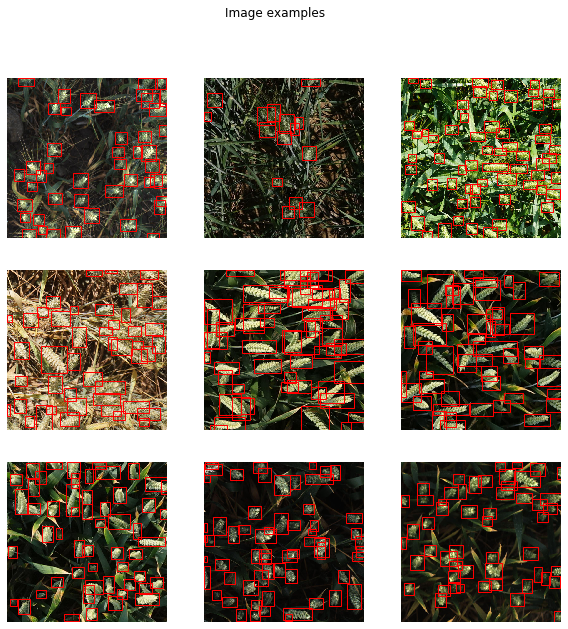

In [7]:
plot_image_examples(all_train_images)

We can see images taken at different lighting conditions and plant maturity stages!

Count number of bounding boxes per image:

In [8]:
# compute the number of bounding boxes per train image
all_train_images['count'] = all_train_images.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
train_images_count = all_train_images.groupby('image_id').sum().reset_index()

In [9]:
# See this article on how to plot bar charts with Bokeh:
# https://towardsdatascience.com/interactive-histograms-with-bokeh-202b522265f3
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 600,
          title = title,
          x_axis_label = column,
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [10]:
hist_hover(train_images_count, 'count', title='Number of wheat spikes per image')

Loading BokehJS ...

Most of the images have 20-50 wheat spikes on them.

Let's plot some examples with small number of spikes per image:

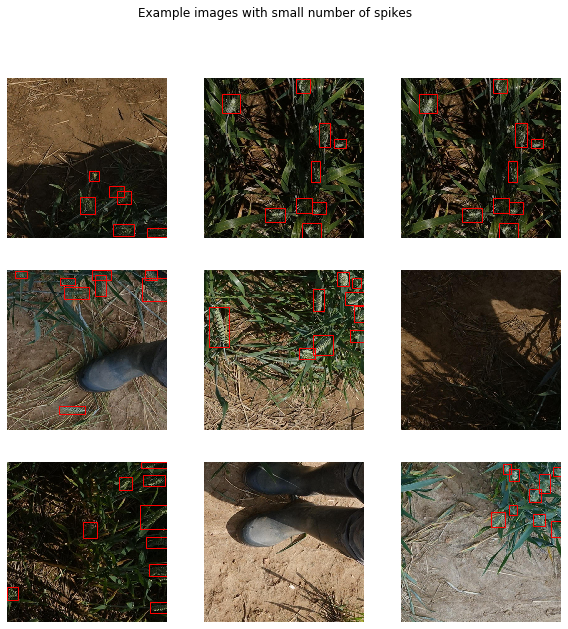

In [11]:
less_spikes_ids = train_images_count[train_images_count['count'] < 10].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(less_spikes_ids)], title='Example images with small number of spikes')

These are some very strange examples:
* on some of the images all we see is the ground;
* some of the images are just zoomed in a lot.

Plot the images with many spikes:

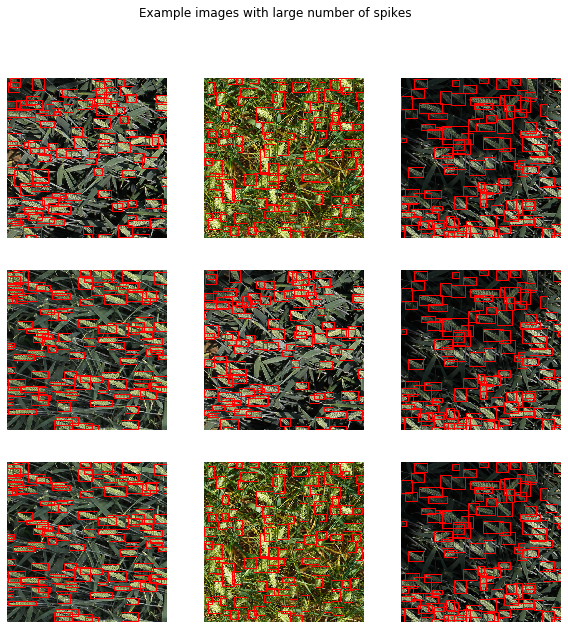

In [12]:
many_spikes_ids = train_images_count[train_images_count['count'] > 100].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(many_spikes_ids)], title='Example images with large number of spikes')

These actually look much better than those with small number of spikes.

`3` Area of bounding boxes:

In [13]:
# compute bounding box areas
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']

In [14]:
# plot a histogram of bounding box areas
hist_hover(all_train_images, 'bbox_area', title='Area of a single bounding box')

Loading BokehJS ...

The maximum area of bounding box:

In [15]:
all_train_images.bbox_area.max()

529788.0

The distribution of individual areas of bounding boxes has a very long tail. It would be interesting to look at the images with those large bounding boxes.

Let's plot some examples of large bounding boxes:

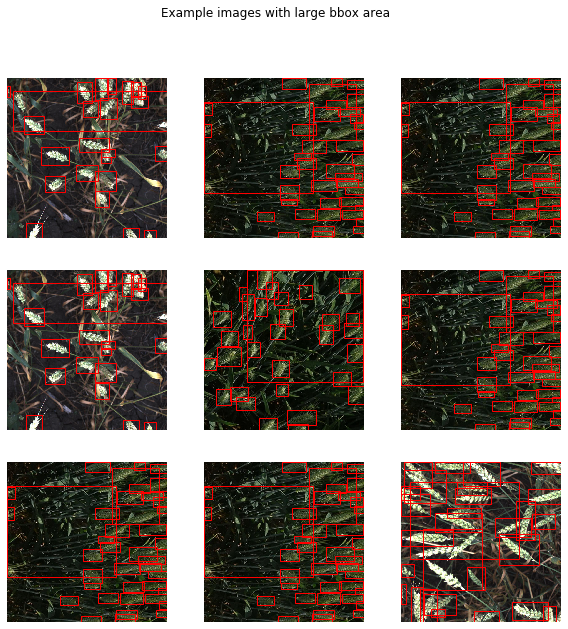

In [16]:
large_boxes_ids = all_train_images[all_train_images['bbox_area'] > 200000].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(large_boxes_ids)], title='Example images with large bbox area')

__What are these anomally large bounding boxes?? I think those should be removed while training!!!__

Similarly, let's look at very small bounding boxes:

In [17]:
min_area = all_train_images[all_train_images['bbox_area'] > 0].bbox_area.min()
print('The smallest bounding box area is {}'.format(min_area))

The smallest bounding box area is 2.0


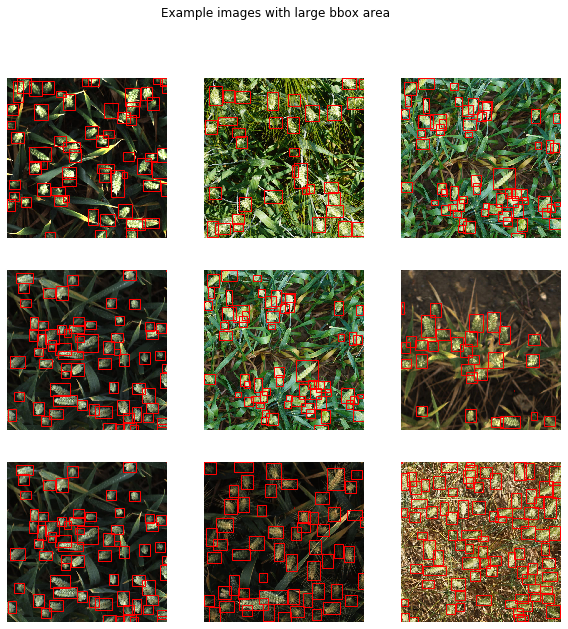

In [18]:
small_boxes_ids = all_train_images[(all_train_images['bbox_area'] < 50) & (all_train_images['bbox_area'] > 0)].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(small_boxes_ids)], title='Example images with large bbox area')

If you look very close, you can probably see those tinyest bounding boxes near the corners and borders of the images. Probably, the boundries were drawn first, than the images were cut into several ones. That is why we see those strange small bounsing boxes in the corners.

It is not necessary to clean these, because they won't have much effect on the IOU metric.

`4` Area of bounding boxes per image:

In [19]:
# compute the total bounding boxes area per image
area_per_image = all_train_images.groupby(by='image_id').sum().reset_index()

# compute the percentage of the image area covered by bounding boxes
area_per_image_percentage = area_per_image.copy()
area_per_image_percentage['bbox_area'] = area_per_image_percentage['bbox_area'] / (1024*1024) * 100

In [20]:
hist_hover(area_per_image_percentage, 'bbox_area', title='Percentage of image area covered by bounding boxes')

Loading BokehJS ...

This looks like a nice normal distribution! 20-40% of the image area is covered by the bounding boxes.

This observation can be used to validate the predictions of the resulting model. The percentage of predicted bounding boxes area should be normally distributed too.

We can also see that the maximum is actually greater than 100%. This means that the bounding boxes are overlapping.

Let's look at some examples of images with small areas covered by bounding boxes:

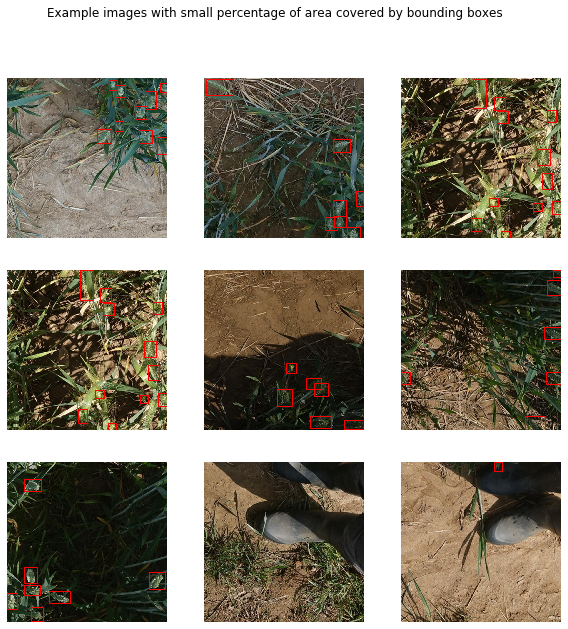

In [21]:
small_area_perc_ids = area_per_image_percentage[area_per_image_percentage['bbox_area'] < 7].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(small_area_perc_ids)], title='Example images with small percentage of area covered by bounding boxes')

Now let's plot the images with large areas covered by bounding boxes:

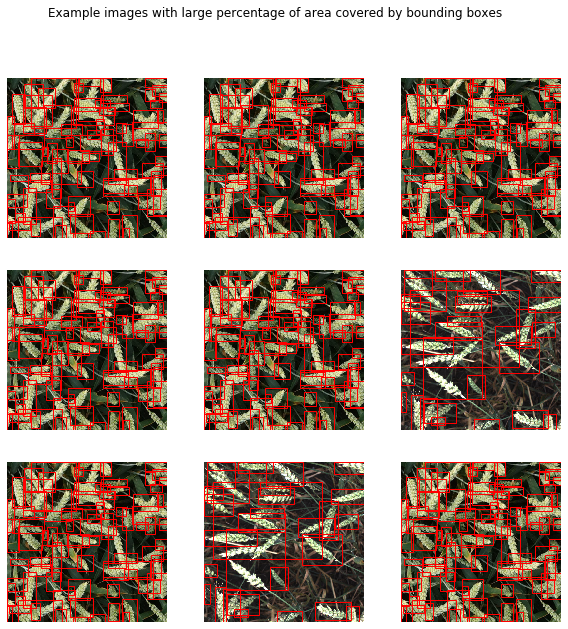

In [22]:
large_area_perc_ids = area_per_image_percentage[area_per_image_percentage['bbox_area'] > 95].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(large_area_perc_ids)], title='Example images with large percentage of area covered by bounding boxes')

`5` The brightness of the images:

In [23]:
def get_image_brightness(image):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # get average brightness
    return np.array(gray).mean()

def add_brightness(df):
    brightness = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(TRAIN_DIR + img_id + '.jpg')
        brightness.append(get_image_brightness(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['brightness']
    df = pd.concat([df, brightness_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'brightness']
    
    return df

In [24]:
images_df = pd.DataFrame(all_train_images.image_id.unique())
images_df.columns = ['image_id']

In [25]:
# add brightness to the dataframe
images_df = pd.DataFrame(all_train_images.image_id.unique())
images_df.columns = ['image_id']
brightness_df = add_brightness(images_df)

all_train_images = all_train_images.merge(brightness_df, on='image_id')

In [26]:
hist_hover(all_train_images, 'brightness', title='Images brightness distribution')

Loading BokehJS ...

Plot the darkest images:

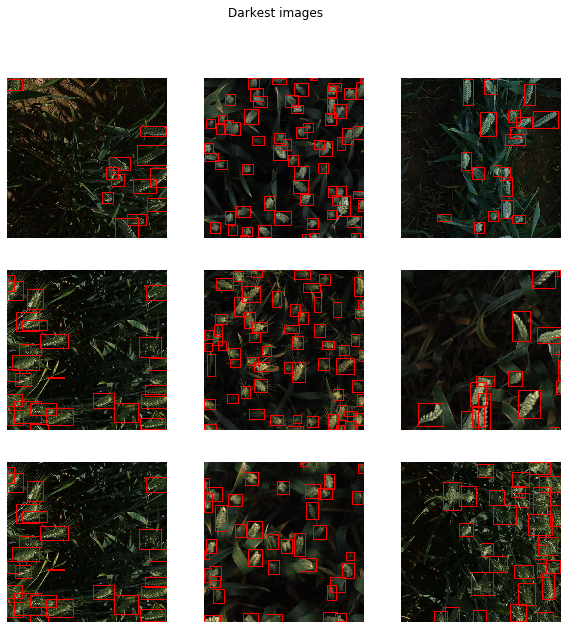

In [27]:
dark_ids = all_train_images[all_train_images['brightness'] < 30].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(dark_ids)], title='Darkest images')

On some of the images, it is even hard for human to see the spikes!

Plot the brightest images:

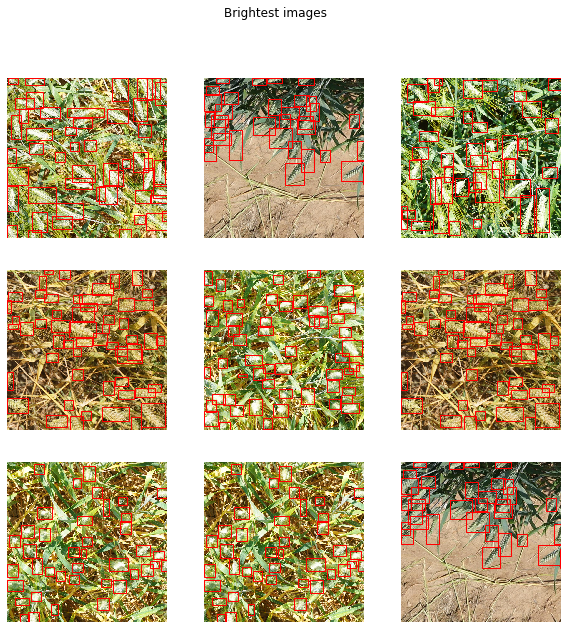

In [28]:
bright_ids = all_train_images[all_train_images['brightness'] > 130].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(bright_ids)], title='Brightest images')

These are very different from the dark ones. Some filters needed here to make the spikes more clear.

I also see the missing boundaries.

`6` The most and the least green and yellow images:

I would like to plot images with different dominant colors. The idea is that the most green images will represent healthy plants. The most yellow images will contain plants close to maturity. The most brown images will have ground on them.

In [29]:
def get_percentage_of_green_pixels(image):
    # convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # get the green mask
    hsv_lower = (40, 40, 40) 
    hsv_higher = (70, 255, 255)
    green_mask = cv2.inRange(hsv, hsv_lower, hsv_higher)
    
    return float(np.sum(green_mask)) / 255 / (1024 * 1024)

def get_percentage_of_yellow_pixels(image):
    # convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # get the green mask
    hsv_lower = (25, 40, 40) 
    hsv_higher = (35, 255, 255)
    yellow_mask = cv2.inRange(hsv, hsv_lower, hsv_higher)
    
    return float(np.sum(yellow_mask)) / 255 / (1024 * 1024)

def add_green_pixels_percentage(df):
    green = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(TRAIN_DIR + img_id + '.jpg')
        green.append(get_percentage_of_green_pixels(image))
        
    green_df = pd.DataFrame(green)
    green_df.columns = ['green_pixels']
    df = pd.concat([df, green_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'green_pixels']
    
    return df

def add_yellow_pixels_percentage(df):
    yellow = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(TRAIN_DIR + img_id + '.jpg')
        yellow.append(get_percentage_of_yellow_pixels(image))
        
    yellow_df = pd.DataFrame(yellow)
    yellow_df.columns = ['yellow_pixels']
    df = pd.concat([df, yellow_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'yellow_pixels']
    
    return df

In [30]:
# add a column with the percentage of green pixels
green_pixels_df = add_green_pixels_percentage(images_df)
all_train_images = all_train_images.merge(green_pixels_df, on='image_id')

In [31]:
hist_hover(all_train_images, 'green_pixels', title='Percentage of green pixels distribution', colors=['#c3ea84', '#3e7a17'])

Loading BokehJS ...

Surprisingly, the most green images have only aoung 60% green pixels.

The majority of the images are not green at all! Most probably, they are more yellow and are the images of the plants close to harvest.

The most green images:

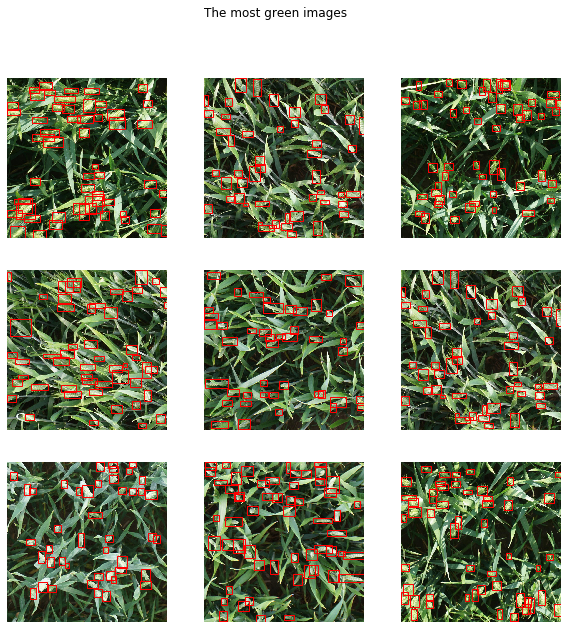

In [32]:
green_ids = all_train_images[all_train_images['green_pixels'] > 0.55].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(green_ids)], title='The most green images')

The most green images mostly contain the plants with very small spikes, which are just starting to appear.

In [33]:
# add a column with the percentage of yellow pixels
yellow_pixels_df = add_yellow_pixels_percentage(images_df)
all_train_images = all_train_images.merge(yellow_pixels_df, on='image_id')

In [34]:
hist_hover(all_train_images, 'yellow_pixels', title='Percentage of yellow pixels distribution', colors=['#fffedb', '#fffeab'])

Loading BokehJS ...

Let's look at the most yellow images:

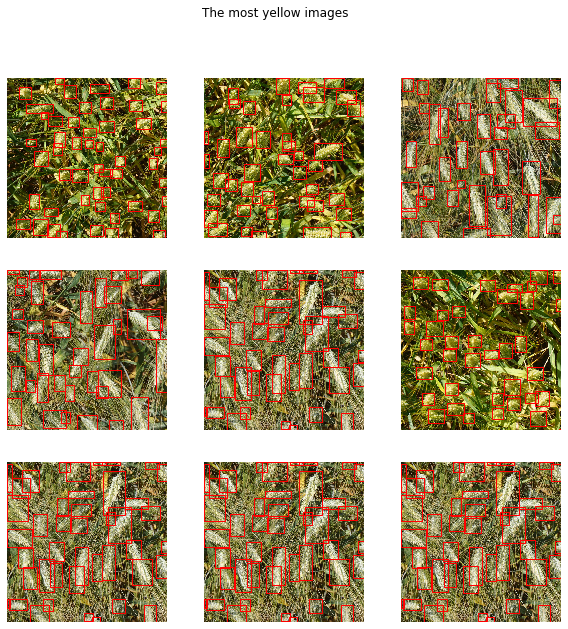

In [35]:
yellow_ids = all_train_images[all_train_images['yellow_pixels'] > 0.55].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(yellow_ids)], title='The most yellow images')

## Thoughts on Data Augmentation

Data augmentation is critical in this competition, because there is a relatively small training set. Data augmentation will allow to build robust models under given circumstances.
What augmentations/filers might work:
* flipping images horizontally and vertically, because the orientation of original images is different;
* crop-resize, because we can see spikes at different zoom levels;
* different filters to adjust the lighting conditions. I suggest looking at [this competition](https://www.kaggle.com/c/aptos2019-blindness-detection) for example.

What to do with caution:
* rotation might not work, because rotation messes up the bounding boxes.

Example augmentation pipeline:

In [36]:
# setup an example augmentation pipeline
# be sure to use bbox safe functions for data augmentation
example_transforms = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness()], p=1.0),
    albu.CLAHE(p=1.0)], p=1.0, bbox_params=albu.BboxParams(format='coco', label_fields=['category_id']))

In [37]:
def apply_transforms(transforms, df, n_transforms=3):
    idx = np.random.randint(len(df), size=1)[0]
    
    image_id = df.iloc[idx].image_id
    bboxes = []
    for _, row in df[df.image_id == image_id].iterrows():
        bboxes.append([row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height])
        
    image = Image.open(TRAIN_DIR + image_id + '.jpg')
    
    fig, axs = plt.subplots(1, n_transforms+1, figsize=(15,7))
    
    # plot the original image
    axs[0].imshow(image)
    axs[0].set_title('original')
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
    
    # apply transforms n_transforms times
    for i in range(n_transforms):
        params = {'image': np.asarray(image),
                  'bboxes': bboxes,
                  'category_id': [1 for j in range(len(bboxes))]}
        augmented_boxes = transforms(**params)
        bboxes_aug = augmented_boxes['bboxes']
        image_aug = augmented_boxes['image']

        # plot the augmented image and augmented bounding boxes
        axs[i+1].imshow(image_aug)
        axs[i+1].set_title('augmented_' + str(i+1))
        for bbox in bboxes_aug:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[i+1].add_patch(rect)
    plt.show()

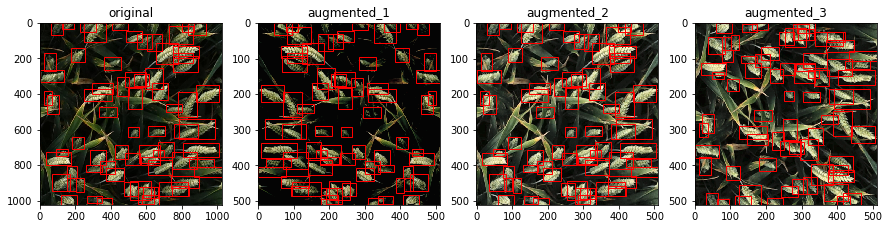

In [38]:
apply_transforms(example_transforms, all_train_images, n_transforms=3)

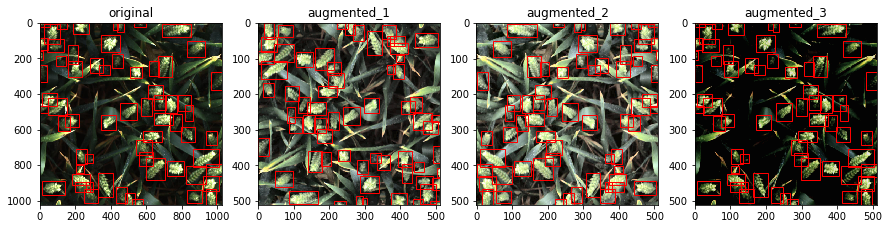

In [39]:
apply_transforms(example_transforms, all_train_images, n_transforms=3)

Note how CLAHE emphasizes the features in darker spots. It is a must have for this competition.

## Conclusions:

1. Images are taken at different zoom levels. Crop and resize data augmentations to be used for model training.
2. Images are taken at various lighting conditions. Special filters should be used to address that.
3. Bounding boxes are messy! 
    * Giant bounding boxes should be filtered out by area and removed before model training.
    * Micro bounding boxes. These can stay. They won't have much effect on the IOU metric.
    * Some spikes are not surrounded by a bounding box (missing bounding boxes).

## Related Papers and Links
I found some interesting papers and articles:
1. [Deep learning based banana plant detection and counting using high-resolution red-green-blue (RGB) images collected from unmanned aerial vehicle (UAV)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0223906). The objective of this research is focused to automate the count of banana plants during early stage of growth, in which they are prone to lose maturity.
2. [Fine-grained recognition of plants from images](https://plantmethods.biomedcentral.com/articles/10.1186/s13007-017-0265-4). Fine-grained recognition of plants from images is a challenging computer vision task, due to the diverse appearance and complex structure of plants, high intra-class variability and small inter-class differences. We review the state-of-the-art and discuss plant recognition tasks, from identification of plants from specific plant organs to general plant recognition “in the wild”.
3. [Review of deep learning algorithms for object detection](https://medium.com/zylapp/review-of-deep-learning-algorithms-for-object-detection-c1f3d437b852)
4. [Fast Detection Models](https://lilianweng.github.io/lil-log/2018/12/27/object-detection-part-4.html)
5. [SSD Tutorial](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection), [SSD implementation in pytorch](https://github.com/qfgaohao/pytorch-ssd)
6. [EfficientDet](https://arxiv.org/pdf/1911.09070.pdf)
7. [CutMix paper](https://arxiv.org/pdf/1905.04899.pdf)

## References & Credits
1. [Article on how to plot bar charts with Bokeh](https://towardsdatascience.com/interactive-histograms-with-bokeh-202b522265f3)

__This EDA is being updated. Your questions and comments are very welcome!__